In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np


# Sketches for automating spatial models 
This notebook is for designing the tool box and methods for fitting spatial data.
I´m using the library Geopystats (before spystats)


## Requirements
* Given a dataset in Geopandas dataframe, create the Variogram object.
And read from the file the variogram data



In [2]:
from external_plugins.spystats import tools
%run ../HEC_runs/fit_fia_logbiomass_logspp_GLS.py

/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/pylabtools.py:168: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)
INFO:__main__:Removing possible duplicates
INFO:__main__:Reading the empirical Variogram file


In [3]:
from external_plugins.spystats import tools
hx = np.linspace(0,800000,100)


The object new_data has been reprojected to Alberts and a linear model have been fitted with residuals stored as *residuals*

In [4]:
new_data.residuals[:10]

0    0.390705
1   -0.499146
2   -0.793889
3   -0.185936
4    0.411008
5    0.294243
6   -0.399424
7    0.834632
8    0.339474
9   -0.152521
Name: residuals, dtype: float64

## The empirical variogram
The empirical variogram has been calculated already using the HEC. A variogram object has been created which takes the values from the previously calculated in HEC

< Whittle Variogram : sill 0.340274671636, range 41061.0511898, nugget 0.32981732354, alpha1.1210178637 >


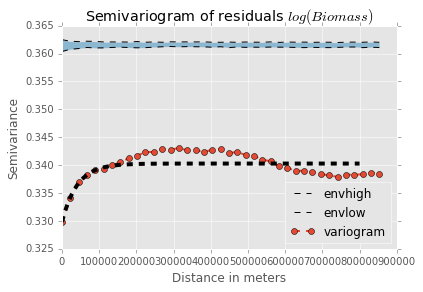

In [5]:
gvg.plot(refresh=False,legend=False,percentage_trunked=20)
plt.title("Semivariogram of residuals $log(Biomass) ~ log(SppR)$")
## HERE we can cast a model (Whittle) and fit it inside the global variogram
whittle_model = tools.WhittleVariogram(sill=0.345,range_a=100000,nugget=0.33,alpha=1.0)
tt = gvg.fitVariogramModel(whittle_model)
plt.plot(hx,gvg.model.f(hx),'--',lw=4,c='black')
print(whittle_model)

In [6]:
## This section is an example for calculating GLS. Using a small section because of computing intensity

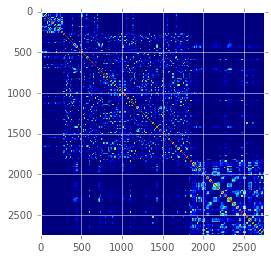

In [7]:
minx = -85
maxx = -80
miny = 30
maxy = 35

section = tools._subselectDataFrameByCoordinates(new_data,'LON','LAT',minx,maxx,miny,maxy)
secvg = tools.Variogram(section,'logBiomass',model=whittle_model)
MMdist = secvg.distance_coordinates.flatten()
CovMat = secvg.model.corr_f(MMdist).reshape(len(section),len(section))
plt.imshow(CovMat)

In [26]:
import statsmodels.regression.linear_model as lm
import statsmodels.api as sm
model1 = lm.GLS.from_formula(formula='logBiomass ~ logSppN',data=section,sigma=CovMat)
results = model1.fit()
resum = results.summary()


In [32]:
k = resum.as_csv()

In [25]:
## Without spatial structure
Id = np.identity(len(section))
model2 = lm.GLS.from_formula(formula='logBiomass ~ logSppN',data=section,sigma=Id)
results = model2.fit()
smm =results.summary()

In [10]:
## Without spatial structure
import statsmodels.formula.api as smf

model3 = smf.ols(formula='logBiomass ~ logSppN',data=section)
results = model3.fit()
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     666.8
Date:                Sun, 10 Dec 2017   Prob (F-statistic):          8.58e-132
Time:                        00:13:27   Log-Likelihood:                -2676.5
No. Observations:                2744   AIC:                             5357.
Df Residuals:                    2742   BIC:                             5369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.3423      0.030    280.887      0.000         8.284     8.401
logSppN        0.4567      0.018     25.822      0.000         0.422     0.491
==============================================================================
Omnibus:                      176.112   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.457
Skew:                          -0.575   Prob(JB):                     7.43e-52
Kurtosis:                       3.860   Cond. No.                         5.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Bonus! simulation of the random processs


In [11]:
from scipy.stats import multivariate_normal as mvn
from scipy.spatial import distance_matrix

In [12]:
n = 50
nx = np.linspace(0,100,n)
xx, yy = np.meshgrid(nx,nx)

points = np.vstack([ xx.ravel(), yy.ravel()]).transpose()## Generate dist matrix
Mdist = distance_matrix(points,points)


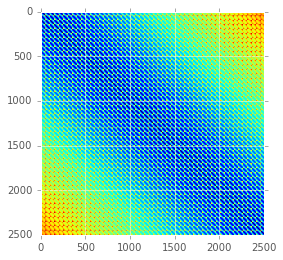

In [13]:
plt.imshow(Mdist)

In [15]:
Mdist.shape
covmat = secvg.model.corr_f(Mdist.flatten()).reshape(Mdist.shape)


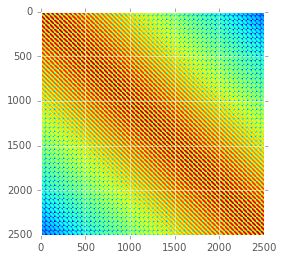

In [16]:

plt.imshow(covmat)


In [18]:
meanx = np.zeros(n*n)
sim1 = mvn.rvs(mean=meanx,cov=covmat)

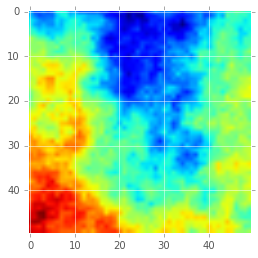

In [24]:
plt.imshow(sim1.reshape(n,n),interpolation=None)

CPU times: user 36.5 s, sys: 1.32 s, total: 37.9 s
Wall time: 19.7 s


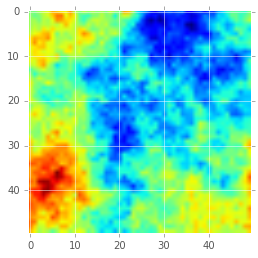

In [23]:
%time sim2 = mvn.rvs(mean=meanx,cov=covmat)
plt.imshow(sim2.reshape(n,n))

# Bonus!
## Fitting the model to the empirical variogram
It´s included as a method in the VariogramModel class.

In [ ]:
matm = tools.MaternVariogram(sill=0.34,range_a=100000,nugget=0.33,kappa=0.5)
expmm = tools.ExponentialVariogram(sill=0.34,range_a=100000,nugget=0.33)
gausms = tools.GaussianVariogram(sill=0.34,range_a=100000,nugget=0.33)
sphmm = tools.SphericalVariogram(sill=0.34,range_a=100000,nugget=0.33)
wm = tools.WhittleVariogram(sill=0.34,range_a=100000,nugget=0.33,alpha=1)
map(lambda l : l.fit(gvg), [matm,expmm,gausms,sphmm,wm])

print(matm)
print(expmm)
print(gausms)
print(sphmm)
print(wm)